In [1]:
import numpy as np
from scipy.sparse import csr_matrix, find
from scipy.spatial import cKDTree
from tqdm import tqdm_notebook as tqdm
from datasets.graph import draw_sample
import torch
import glob

In [2]:
flist = [filepath for filepath in glob.iglob(r'/home/sameasy2006/npz2/photon_hfntup_0to1000/processed/data_*.pt')]
print (len(flist))
flist = flist[13900:14400]  

14400


In [3]:
model_fname = '/home/sameasy2006/hgcal_ldrd-gravnet2_wip_trainer_args/output_photon6nn/checkpoints/model_checkpoint_EdgeNet2_21858_db062f87e7_sameasy2006.best.pth.tar'
from models.EdgeNet2 import EdgeNet2
mdl = EdgeNet2(input_dim=5, hidden_dim=64, output_dim=1, n_iters=6)
mdl.load_state_dict(torch.load(model_fname, map_location=torch.device('cpu'))['model'])
mdl.eval()

EdgeNet2(
  (inputnet): Sequential(
    (0): Linear(in_features=5, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
  )
  (edgenetwork): Sequential(
    (0): Linear(in_features=778, out_features=1, bias=True)
    (1): Sigmoid()
  )
  (nodenetwork): EdgeConv(nn=Sequential(
    (0): Linear(in_features=138, out_features=101, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=101, out_features=64, bias=True)
    (4): ReLU()
  ))
)

In [4]:
def energy(X,Ro,mask):
    Ro = Ro[mask]
    # Select the i/o node features for each segment    
#    feats_o = X[Ro]
    feats_o = X[np.unique(Ro)]
    return feats_o[:,4].sum()

In [5]:


r_tot_predE = []
r_corr_predE = []
for filename in tqdm(flist):
    data = torch.load(filename)
    X = data.x.detach().numpy()
    pred_edges = mdl(data).detach()
    pred_edges_np = pred_edges.numpy()
    index = data.edge_index.numpy().T
    Ro = index[:,0]
    Ri = index[:,1]
    y = data.y.numpy()
    out =pred_edges_np
    
    truth_mask = y > 0.5
    truth_energy = energy(X,Ro,truth_mask)
    pred_mask = out > 0.5
    pred_energy = energy(X,Ro,pred_mask)
    corr_pred_mask = (out >0.5) & (y > 0.5)
    corr_pred_energy = energy(X,Ro,corr_pred_mask)

    r_tot_predE.append(pred_energy/truth_energy)
    r_corr_predE.append(corr_pred_energy/truth_energy)
    if (corr_pred_energy/truth_energy == 1):
        print (corr_pred_energy,truth_energy,pred_energy)
    
    

/home/sameasy2006/miniconda3/envs/mlgnn/lib/python3.6/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


18.85528 18.85528 34.131573
53.843605 53.843605 53.92785
173.0018 173.0018 173.08026
32.84098 32.84098 32.878227
251.83551 251.83551 251.89012


/home/sameasy2006/miniconda3/envs/mlgnn/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in float_scalars
/home/sameasy2006/miniconda3/envs/mlgnn/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in float_scalars
/home/sameasy2006/miniconda3/envs/mlgnn/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in float_scalars


41.128155 41.128155 102.47792
17.617903 17.617903 17.617903
59.874058 59.874058 59.874058
6.983644 6.983644 6.983644
45.21996 45.21996 45.701687



/home/sameasy2006/miniconda3/envs/mlgnn/lib/python3.6/site-packages/numpy/core/_methods.py:193: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


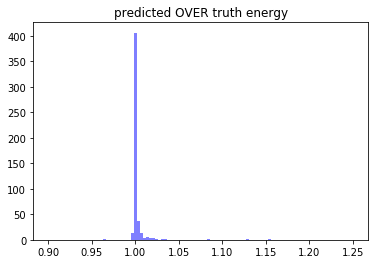

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
mu, sigma = (np.mean(r_tot_predE), np.std(r_tot_predE))
plt.hist(r_tot_predE, bins=100,range=[0.9,1.25],color='blue', alpha=0.5)
plt.title('predicted OVER truth energy')
plt.show()

/home/sameasy2006/miniconda3/envs/mlgnn/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/sameasy2006/miniconda3/envs/mlgnn/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


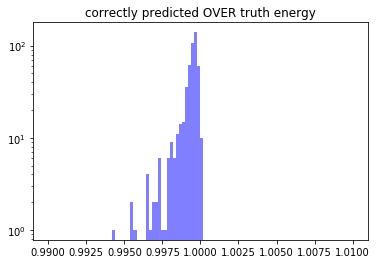

In [7]:

mu, sigma = (np.mean(r_corr_predE), np.std(r_corr_predE))
textstr = '\n'.join((
    r'$\mu=%.2f$' % (mu, ),
#    r'$\mathrm{median}=%.2f$' % (median, ),
    r'$\sigma=%.2f$' % (sigma, )))

#print (mu,sigma)
plt.hist(r_corr_predE, bins=100,range=[0.99,1.01],color='blue', alpha=0.5)
plt.title('correctly predicted OVER truth energy')
#plt.text(0.05, 0.95, textstr,  fontsize=14,verticalalignment='top')    
plt.yscale('log')
plt.show()

In [8]:
print(r_corr_predE)

[0.9994305, 0.9992516, 0.9998194, 0.99911183, 0.9997346, 0.99943435, 0.99951893, 0.9993538, 0.99852556, 0.9996459, 0.99958, 0.99722636, 0.9994152, 0.9998671, 0.9993489, 0.99870294, 0.99931157, 0.999255, 0.9993732, 0.9995027, 0.99968576, 0.9997556, 0.9996714, 0.9996443, 0.9994212, 0.9992449, 0.9998324, 0.9995951, 0.9996304, 0.99927187, 0.99951327, 0.9997669, 0.99964786, 0.9980931, 0.9997762, 0.9996017, 0.9990078, 0.99968827, 0.9993205, 0.99957025, 0.99935925, 0.99867177, 0.99968904, 0.99833393, 0.99960816, 0.9955289, 0.99970317, 0.99909425, 0.998138, 0.99960244, 0.99975675, 0.99934965, 0.9998226, 0.9989024, 0.9998925, 0.9997315, 0.99926025, 0.99968356, 0.99980354, 0.9993207, 0.9994877, 0.99959403, 0.9989441, 0.9942141, 0.9998618, 0.9992761, 0.99843323, 0.9998765, 0.9997671, 0.99652797, 0.9999253, 0.9990291, 0.99968255, 0.99955624, 0.99973536, 0.99875873, 0.9996749, 0.99980426, 0.99889386, 0.9995136, 0.99547493, 0.9988847, 1.0, 0.999766, 0.99938625, 0.9987363, 0.9988495, 0.9991638, 0.999

In [20]:
test_fname = '/home/sameasy2006/npzpion_k6/pion_hfntup_0to1000/processed/data_299.pt'
data = torch.load(test_fname)
X = data.x.detach().numpy()
pred_edges = mdl(data).detach()
pred_edges_np = pred_edges.numpy()
index = data.edge_index.numpy().T
Ro = index[:,0]
Ri = index[:,1]
y = data.y.numpy()
out =pred_edges_np

In [21]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib import collections  as mc
import tqdm

def draw_sample(X, Ri, Ro, y, out,
                cmap='bwr_r', 
                skip_false_edges=True,
                alpha_labels=False, 
                sim_list=None): 
    
    #let's draw only the non-noise edges
    out_mask = out >0.5
    Ri = Ri[out_mask]
    Ro = Ro[out_mask]
    good_outs = out[out_mask]
    
#    print('out value:',out)
#    print('good_outs:',good_outs)
#    X[:,2]=X[:,2]*150.0
    # Select the i/o node features for each segment    
    feats_o = X[Ro]
    feats_i = X[Ri]  
    
    print(feats_o.shape)
    # Prepare the figure
    fig, (ax0,ax1) = plt.subplots(1, 2, figsize=(20,12))
    cmap = plt.get_cmap(cmap)
    
#    print(X[:,0])
#    print(X[:,1])
    #print(X[:,2]*150.0)
#    print(X[:,4])
    #if sim_list is None:    
        # Draw the hits (layer, x, y)
    #    ax0.scatter(X[:,0], X[:,2], c='k')
    #    ax1.scatter(X[:,1], X[:,2], c='k')
    #else:        
    
    e_max = np.max(X[:,4])
#    e_normed = np.tanh(X[:,4]/e_max)#1. / (1. + np.exp(-X[:,4]/e_max))
    e_normed = 100*X[:,4]
    ax0.scatter(X[:,0], X[:,2], s=(e_normed), c='r',alpha=0.2)
    ax1.scatter(X[:,1], X[:,2], s=(e_normed), c='r',alpha=0.2)
    
    
    
       
    lines0 = []
    lines1 = []
    colors = []
    # Draw the segments    
    if out is not None:
        #t = tqdm.tqdm()
        color_map = {0: (1,1,1,1),
                     1: (0,0,1,1),
                     2: (1,0,0,1),
                     3: (0,1,0,1)}
        
        for j in tqdm.tqdm(range(good_outs.shape[0])):
            
            lines0.append([(feats_o[j,0], feats_o[j,2]),(feats_i[j,0], feats_i[j,2])])
            lines1.append([(feats_o[j,1], feats_o[j,2]),(feats_i[j,1], feats_i[j,2])])
#            colors.append(color_map[good_outs[j]])
            colors.append(color_map[1])
            #_ = ax0.plot([feats_o[j,0], feats_i[j,0]],
            #             [feats_o[j,2], feats_i[j,2]], '-', **seg_args)
            #_ = ax1.plot([feats_o[j,1], feats_i[j,1]],
            #             [feats_o[j,2], feats_i[j,2]], '-', **seg_args)
    else:
        t = tqdm.tqdm(range(y.shape[0]))
        for j in t:
            if y[j]:
                seg_args = dict(c='b', alpha=0.4)
            elif not skip_false_edges:
                seg_args = dict(c='black', alpha=0.4)
            else: continue
                
            ax0.plot([feats_o[j,0], feats_i[j,0]],
                     [feats_o[j,2], feats_i[j,2]], '-', **seg_args)
            ax1.plot([feats_o[j,1], feats_i[j,1]],
                     [feats_o[j,2], feats_i[j,2]], '-', **seg_args)
        
    col_arr = np.array(colors)
    lc0 = mc.LineCollection(lines0, colors=col_arr, linewidths=1)
    lc1 = mc.LineCollection(lines1, colors=col_arr, linewidths=1)
    
    ax0.add_collection(lc0)
    ax1.add_collection(lc1)
    
    # Adjust axes
    ax0.set_xlabel('$x$ [cm]')
    ax1.set_xlabel('$y$ [cm]')
    ax0.set_ylabel('$layer$ [arb]')
    ax1.set_ylabel('$layer$ [arb]')
    plt.tight_layout()
    return fig;
    

100%|██████████| 2292/2292 [00:00<00:00, 213881.79it/s]

(2292, 5)


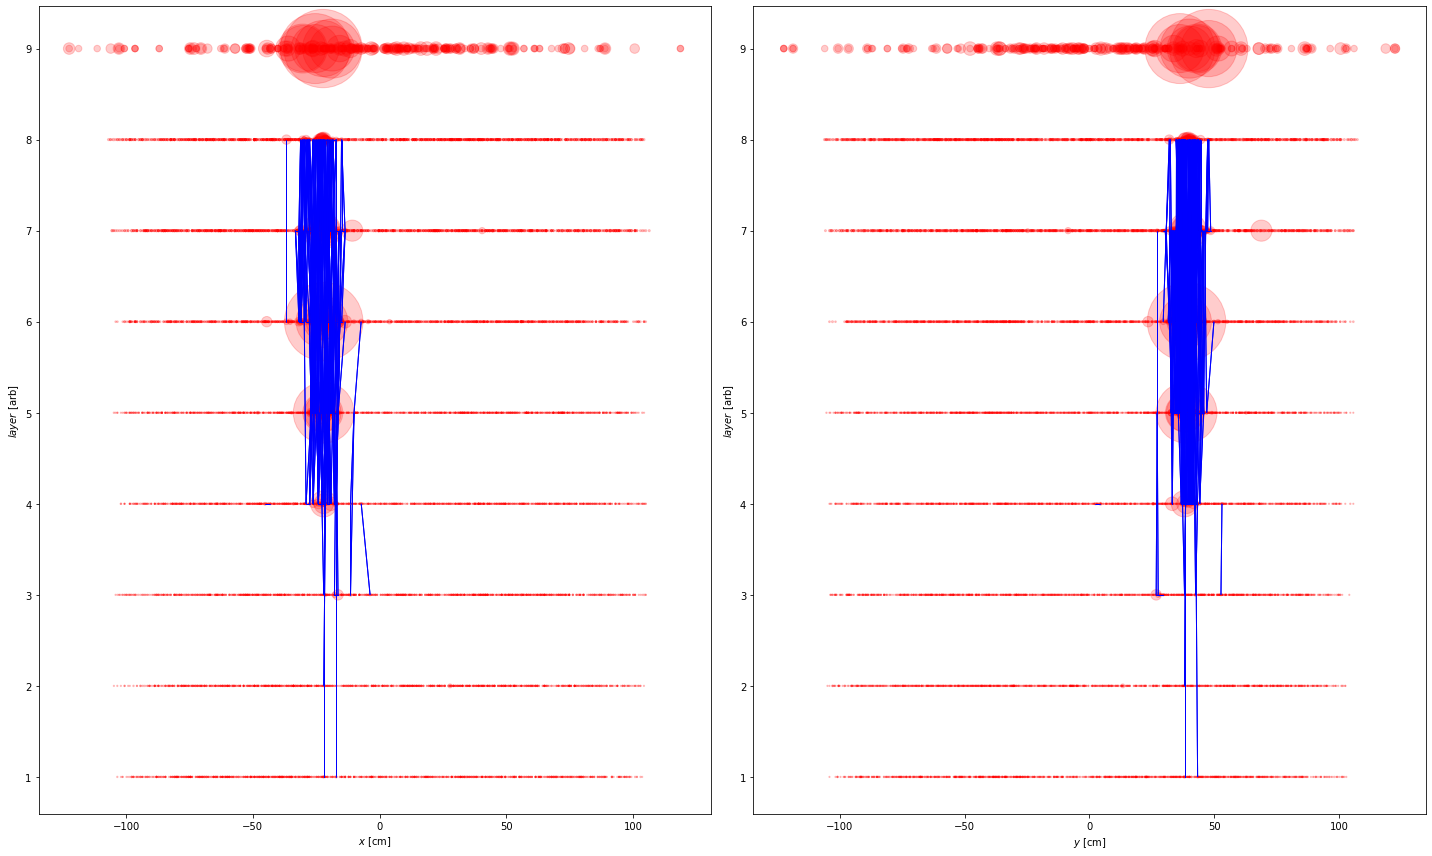

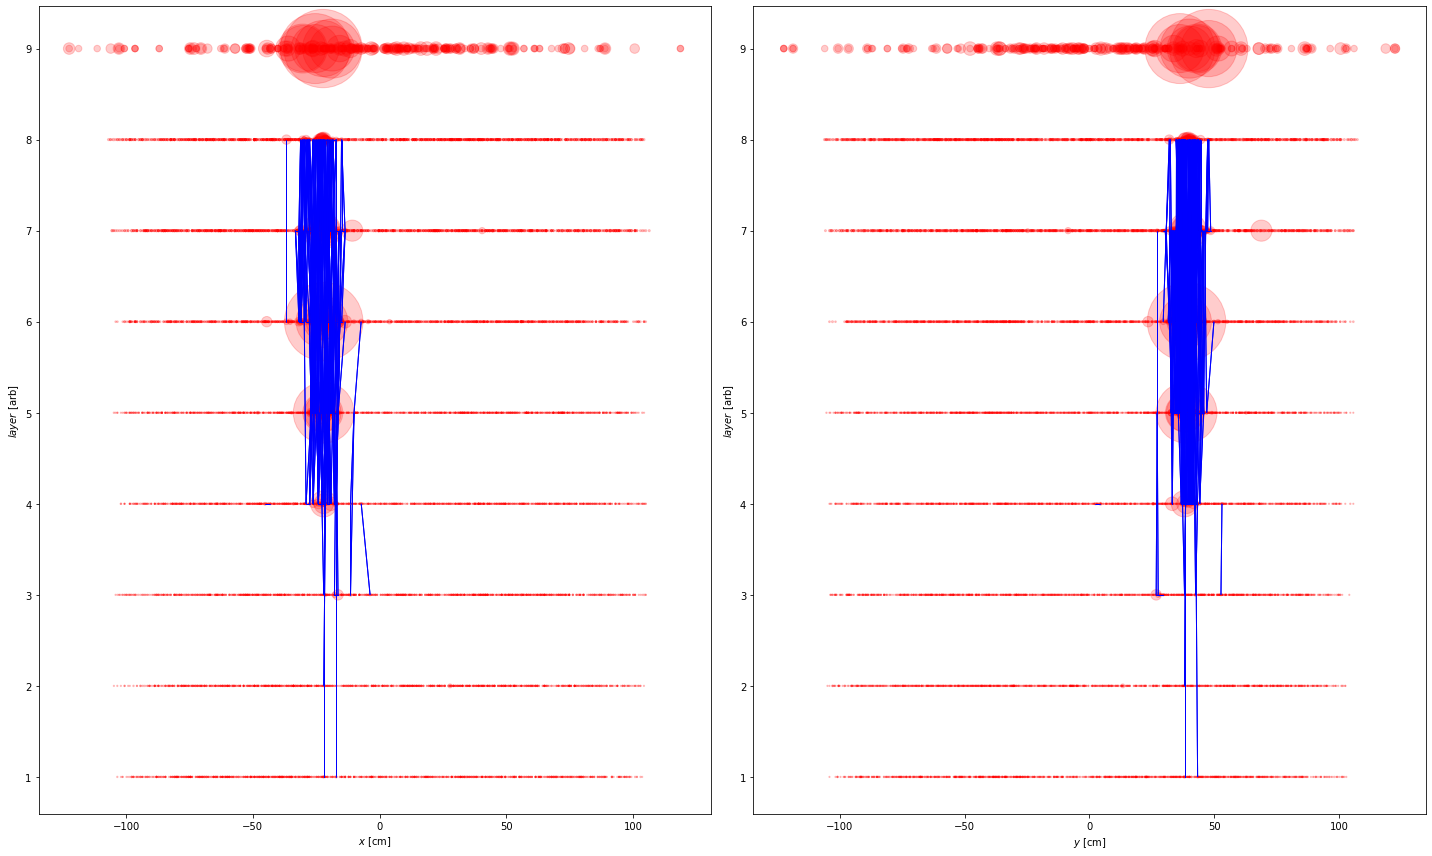

In [22]:
draw_sample(X, Ri, Ro, y, y)

100%|██████████| 2306/2306 [00:00<00:00, 202968.65it/s]

(2306, 5)


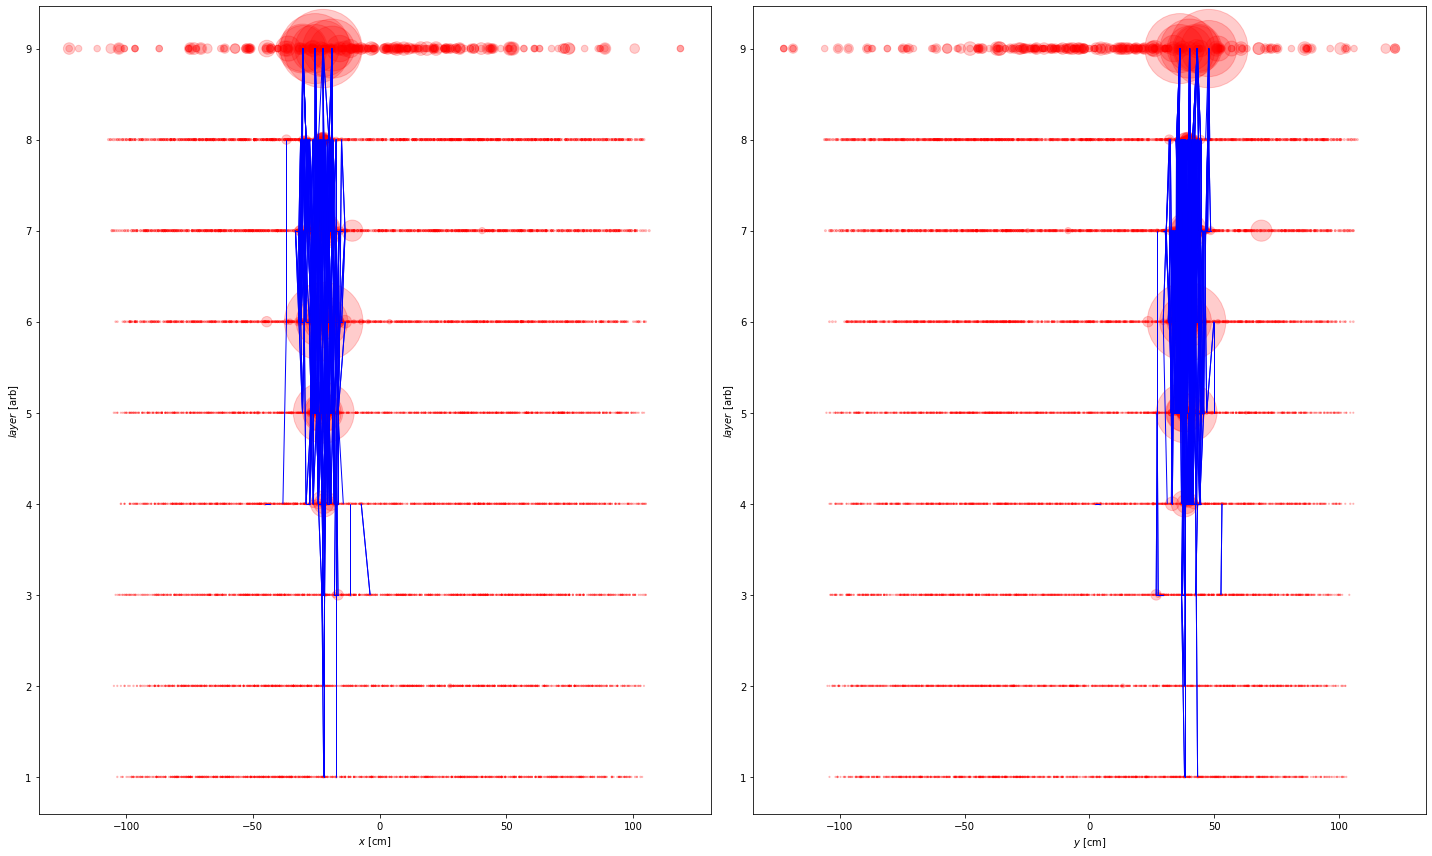

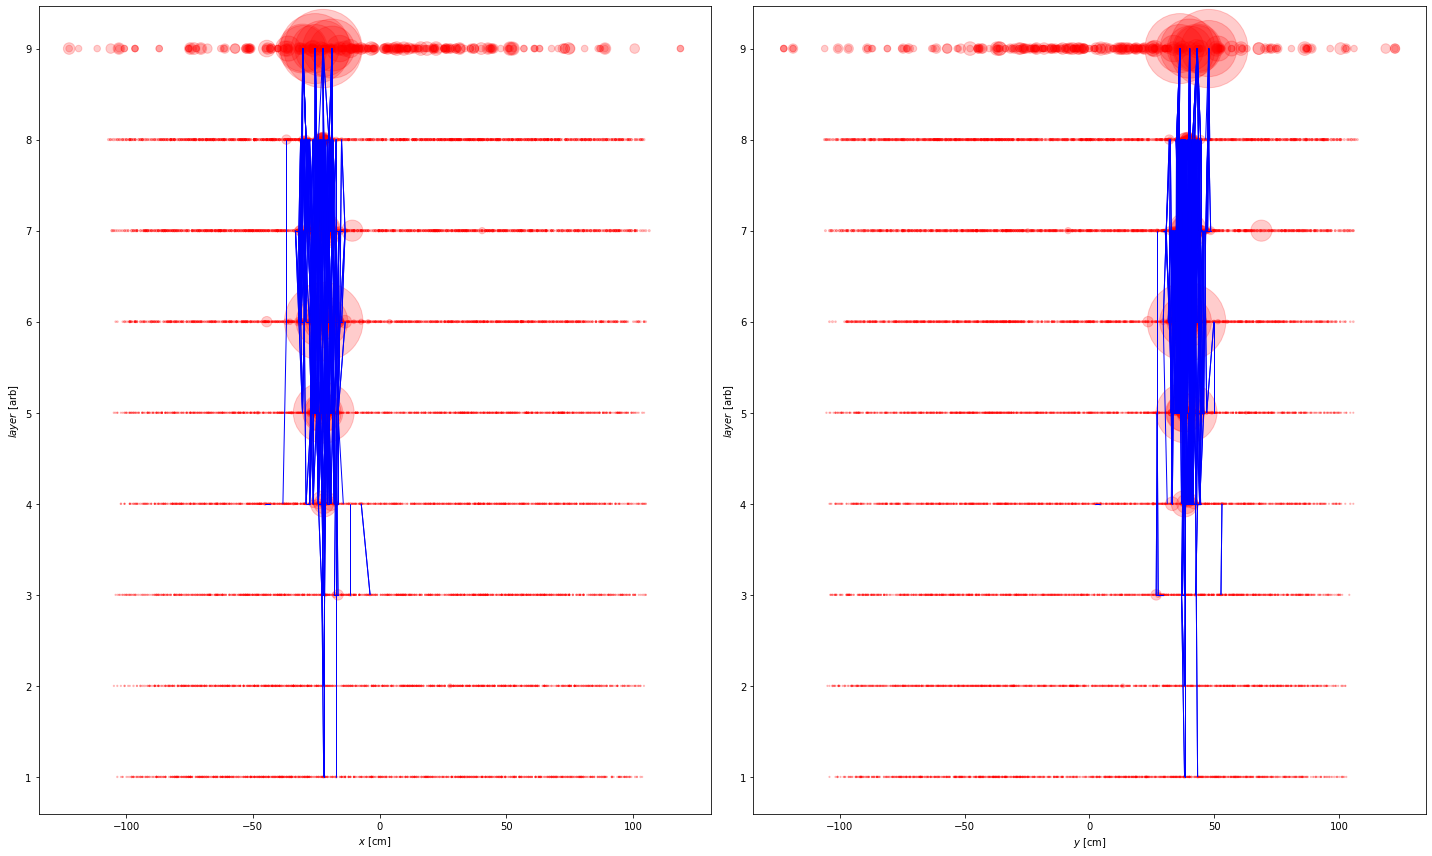

In [23]:
draw_sample(X, Ri, Ro, y, out)

In [24]:
def draw_sample(X, Ri, Ro, y, out,
                cmap='bwr_r', 
                skip_false_edges=True,
                alpha_labels=False, 
                sim_list=None): 
    
    #let's draw only the non-noise edges
#    out_mask = (out >0.5) & (y > 0.5) ### only the correctly predicted signal edges
#    out_mask = (out >0.5) & (y < 0.5) ### only the incorrectly predicted signal edges
#    out_mask =  (y > 0.5) & (out <0.5)  ### signal incorrectly predicted as background
    out_mask =  (y < 0.5) & (out >0.5)  ### background incorrectly predicted as signal
    Ri = Ri[out_mask]
    Ro = Ro[out_mask]
    good_outs = out[out_mask]
    
#    print('out value:',out)
#    print('good_outs:',good_outs)
#    X[:,2]=X[:,2]*150.0
    # Select the i/o node features for each segment    
    feats_o = X[Ro]
    feats_i = X[Ri]  
    
    print(feats_o.shape)
    # Prepare the figure
    fig, (ax0,ax1) = plt.subplots(1, 2, figsize=(20,12))
    cmap = plt.get_cmap(cmap)
    
#    print(X[:,0])
#    print(X[:,1])
    #print(X[:,2]*150.0)
#    print(X[:,4])
    #if sim_list is None:    
        # Draw the hits (layer, x, y)
    #    ax0.scatter(X[:,0], X[:,2], c='k')
    #    ax1.scatter(X[:,1], X[:,2], c='k')
    #else:        
    
    e_max = np.max(X[:,4])
#    e_normed = np.tanh(X[:,4]/e_max)#1. / (1. + np.exp(-X[:,4]/e_max))
    e_normed = 100*X[:,4]
    ax0.scatter(X[:,0], X[:,2], s=(e_normed), c='r',alpha=0.2)
    ax1.scatter(X[:,1], X[:,2], s=(e_normed), c='r',alpha=0.2)
    
    
    
       
    lines0 = []
    lines1 = []
    colors = []
    # Draw the segments    
    if out is not None:
        #t = tqdm.tqdm()
        color_map = {0: (1,1,1,1),
                     1: (0,0,1,1),
                     2: (1,0,0,1),
                     3: (0,1,0,1)}
        
        for j in tqdm.tqdm(range(good_outs.shape[0])):
            
            lines0.append([(feats_o[j,0], feats_o[j,2]),(feats_i[j,0], feats_i[j,2])])
            lines1.append([(feats_o[j,1], feats_o[j,2]),(feats_i[j,1], feats_i[j,2])])
#            colors.append(color_map[good_outs[j]])
            colors.append(color_map[1])
            #_ = ax0.plot([feats_o[j,0], feats_i[j,0]],
            #             [feats_o[j,2], feats_i[j,2]], '-', **seg_args)
            #_ = ax1.plot([feats_o[j,1], feats_i[j,1]],
            #             [feats_o[j,2], feats_i[j,2]], '-', **seg_args)
    else:
        t = tqdm.tqdm(range(y.shape[0]))
        for j in t:
            if y[j]:
                seg_args = dict(c='b', alpha=0.4)
            elif not skip_false_edges:
                seg_args = dict(c='black', alpha=0.4)
            else: continue
                
            ax0.plot([feats_o[j,0], feats_i[j,0]],
                     [feats_o[j,2], feats_i[j,2]], '-', **seg_args)
            ax1.plot([feats_o[j,1], feats_i[j,1]],
                     [feats_o[j,2], feats_i[j,2]], '-', **seg_args)
        
    col_arr = np.array(colors)
    lc0 = mc.LineCollection(lines0, colors=col_arr, linewidths=1)
    lc1 = mc.LineCollection(lines1, colors=col_arr, linewidths=1)
    
    ax0.add_collection(lc0)
    ax1.add_collection(lc1)
    
    # Adjust axes
    ax0.set_xlabel('$x$ [cm]')
    ax1.set_xlabel('$y$ [cm]')
    ax0.set_ylabel('$layer$ [arb]')
    ax1.set_ylabel('$layer$ [arb]')
    plt.tight_layout()
    return fig;
    

100%|██████████| 121/121 [00:00<00:00, 30486.62it/s]

(121, 5)


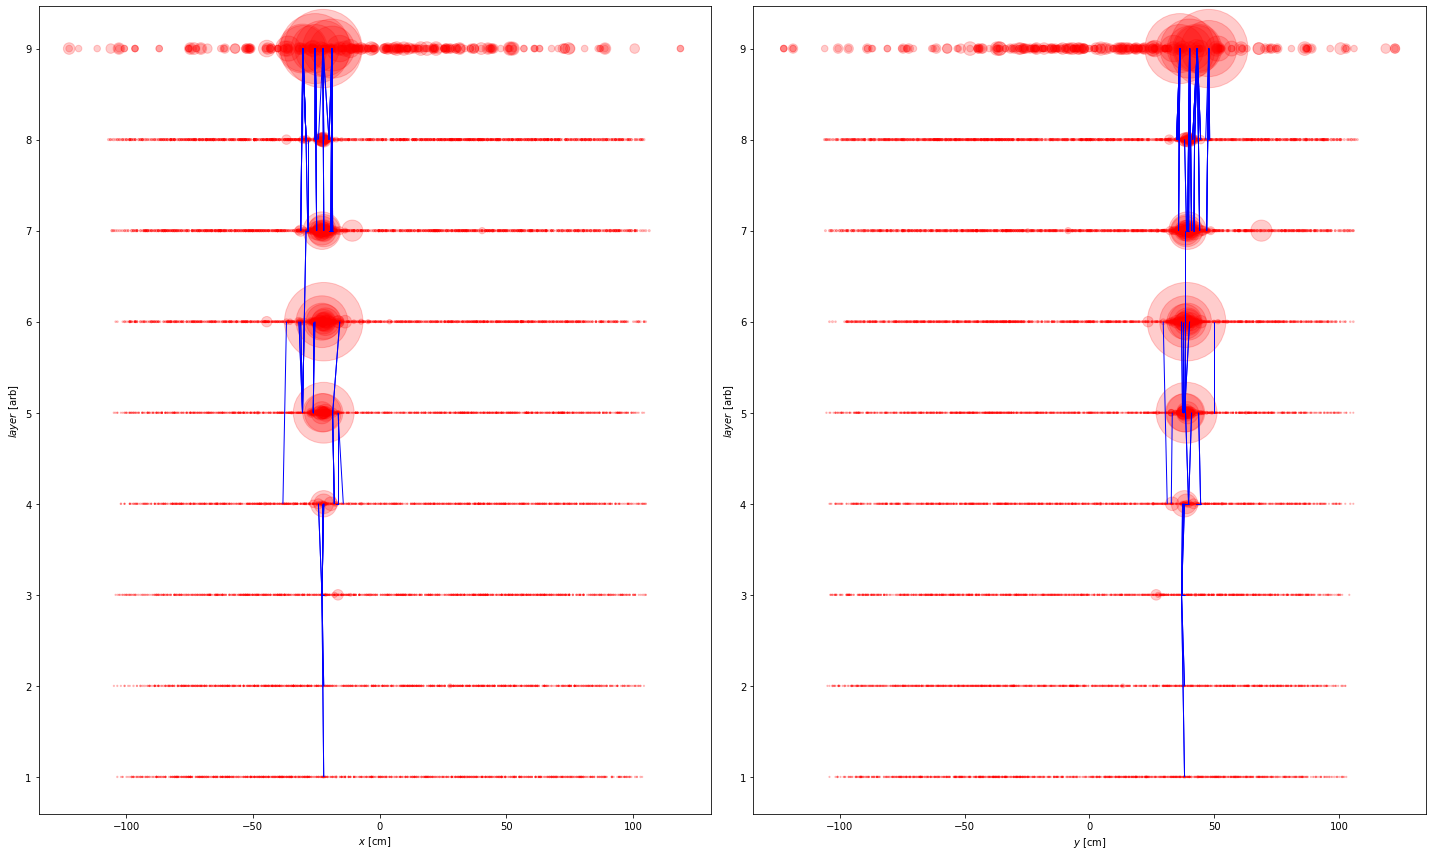

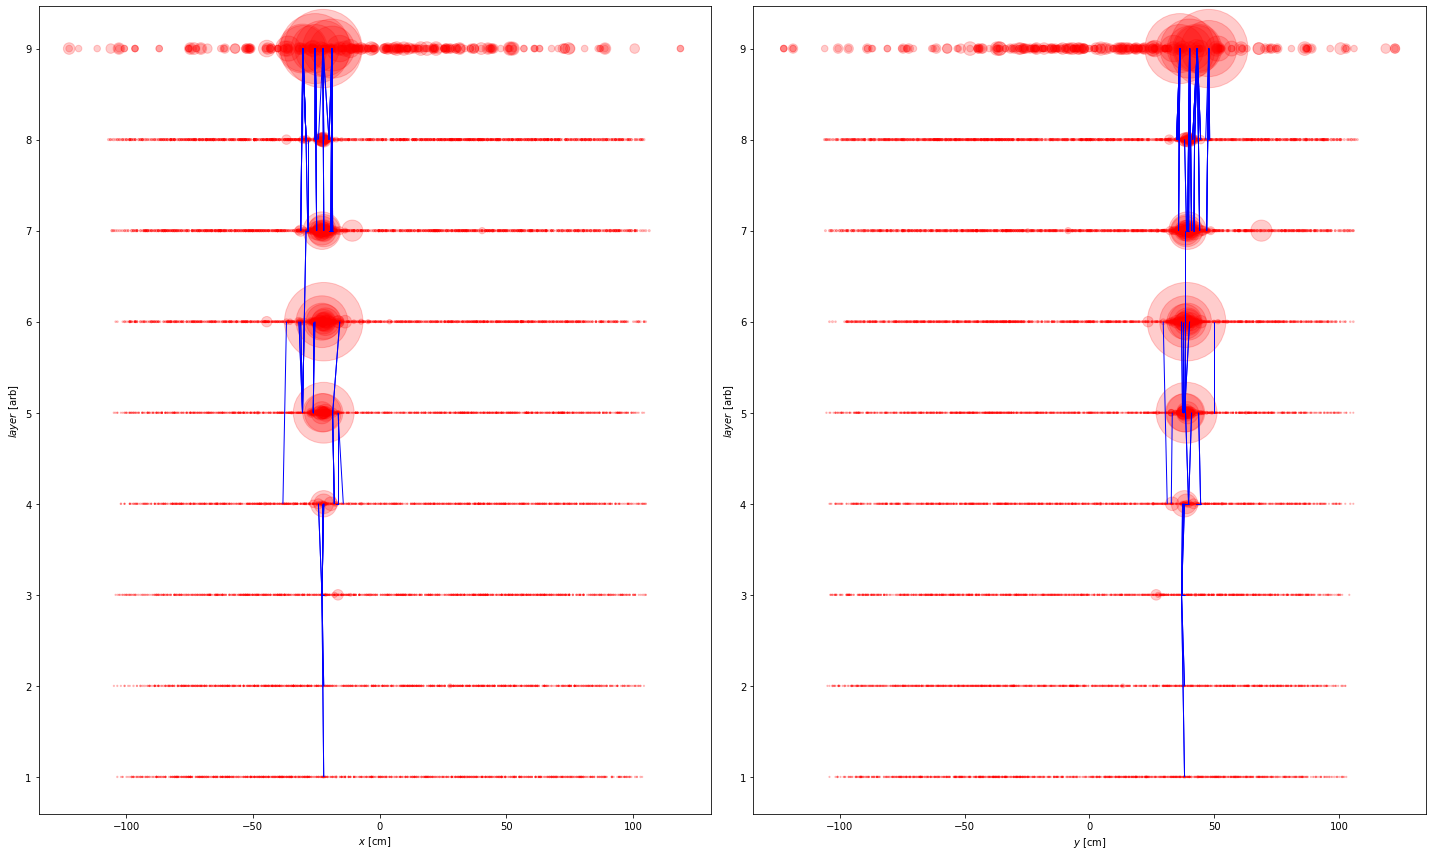

In [25]:
draw_sample(X, Ri, Ro, y, out)

In [26]:
datas = torch.load(test_fname)

In [27]:
datas

Data(edge_index=[2, 65666], x=[10669, 5], y=[65666])

In [17]:
datas.x

tensor([[-3.7409e+01, -2.4168e+00,  1.0000e+00, -1.0000e+00,  2.2204e-02],
        [-3.6711e+01, -2.0140e+00,  1.0000e+00, -1.0000e+00,  1.7270e-02],
        [-3.3921e+01,  5.2364e+00,  1.0000e+00, -1.0000e+00,  1.7270e-02],
        ...,
        [-1.1134e+01, -9.3425e+00,  9.0000e+00,  0.0000e+00,  8.8299e-01],
        [-1.3658e+01, -4.9711e+00,  9.0000e+00,  0.0000e+00,  4.2845e-01],
        [-1.4534e+01,  2.5413e-06,  9.0000e+00,  0.0000e+00, -2.6100e-02]])

In [18]:
X = datas.x.detach().numpy()

In [19]:
X.shape

(10986, 5)